# Animal Classifier

- pip install pillow may be required

## Overview
Have you ever wanted to try machine learning? If so, this is the tutorial for you. You’ll learn to build an image classifier and train it using Cloud GPUs.  What is an image classifier? It is a machine learning model which can classify an image. You’ll show it an image, and it’ll tell you what it thinks it is. Although our model won’t be as accurate as state-of-the-art models, it is a good starting point. 

We will use Cloud GPUs in this tutorial so all you need is a web browser. Our friends at [Tensorpad](https://tensorpad.com/) have graciously provided 5 free hours of GPU compute time with the promo code "ClassifierGuide250". That’s more than enough to complete this tutorial.

## Objective
Our objective is to build an image classifier then use it to make predictions. This process includes the following phases:

1. Building an image dataset (we’ve done this for you)
2. Loading the image dataset in a way that is for efficient training
3. Building the image classifier model
4. Training the model using Cloud GPUs
5. Validating the trained model

It is important to remember that the process above is not linear. Generally, each phase will need to be revisited multiple times to optimize the model’s accuracy.

Additionally, we will also make predictions using the trained model, and export it for use elsewhere.

## Getting started
Follow these steps to try this code:

1. Create a [Tensorpad](https://tensorpad.com) account. Use promo code `ClassifierGuide250` for 5 free hours of GPU compute time.
2. `Create JupyterLab Job` with `TensorFlow 1.11`. Wait for the instance to be created then `Open Lab`. 
3. Open a `Terminal` in the opened lab.
4. Clone this project's [Github repository](https://github.com/PeterChauYEG/animal_classifier) with: `$ git clone https://github.com/PeterChauYEG/animal_classifier.git`
5. Open `Animal Classifier.pynb` inside the `animal_classifier` directory. This will open the Jupyter notebook.
6. Run the whole notebook by using the `Run` menu and selecting `Run All Cells`


## Loading Dependencies
We need to import an number of Python dependencies.

In [1]:
# Allows division to return a float
from __future__ import division

# Allows access to the file system
import os

# Provides an API for scientific computing
import numpy as np

# Allows use to timestamp the training run
from datetime import datetime

# Allows us to render images and plot data
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import math
import matplotlib.pyplot as plt

# Machine learning framework that provides an abstract API on top of Tensorflow
import keras
from keras.callbacks import TensorBoard
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Sequential
from keras import optimizers

Using TensorFlow backend.


## Configurations
Because we are plotting in a Jupyter Lab, we need to configure `matplotlib` to render plots inline.

In [27]:
# configure the matplotlib for Jupyter Lab used for rendering the images
%matplotlib inline

## Functions

In [28]:
def get_class_labels(dir):
    """
    Gets the name of each sub-directory in the given directory.
    
    dir: Directory to search.
    return: An array of the names of the sub-directories in dir.
    """
    
    # Get all sub-directories in this directory
    classes = os.listdir(dir)
    
    return classes

In [4]:
def get_class_images(classes, dir):
    """
    Gets the paths of all images in each directory.
    
    classes: Name of each class.
    dir: Directory to search.
    return: A 2d array of paths organized by class name.
    """
    
    # Create an array to hold the image paths of each class
    class_paths = []

    # Create image paths of each class
    for label in classes:
        
        # Create an array to hold the image paths of this class (label)
        image_paths = np.array([])

        # Create the path of this class
        class_path = os.path.join(dir, label)

        # Get all images in this directory
        images = os.listdir(class_path)

        # Create the path of each images in this class
        for image in images:
            
            # Create the path of this image
            image_path = os.path.join(class_path, image)

            # Add the image path to the image paths array
            image_paths = np.append(image_paths, image_path)

        # Add the image paths to the class paths array
        class_paths.append(image_paths)
        
    return class_paths

In [5]:
def predict(batch_size, image_paths, model):
    """
    Makes predictions with the model
        
    batch_size: number of predictions to make
    image_paths: paths to images
    model: image classifier model
    return: resulting predictions
    """
    
    images_arr = []
    
    # load images     
    for image_path in image_paths:
        # load the image
        image_pil = load_img(image_path, interpolation='nearest', target_size=(image_dim, image_dim, 3))

        # turn it into an array
        image_arr = img_to_array(image_pil)

        # add the image_arr to the images_arr array
        images_arr.append(image_arr)
 
    # turn it into a numpy arrays so that it can be feed into the model as a batch
    images = np.array(images_arr)
    
    # make a predictions on the batch
    predictions = model.predict(images, batch_size=batch_size)

    return predictions

In [6]:
def predictions_accuracy(class_keys, label, predictions):
    """
    Determine the accuracy of a set of a image predictions
    
    class_keys: list of class keys
    label: true class of the predictions
    predictions: array of image predictions
    return: average correct image predictions
    """
    
    # number of correct predictions
    correct_predictions = 0
    
    # number of predictions made
    n_predictions = len(predictions)
    
    # check how many predictions were correct
    for prediction in predictions:
        # determine the most likely class from the prediction
        most_likely_class = np.argmax(prediction)
        
        # get the label of the prediction
        prediction_label = class_keys[most_likely_class]
        
        # check if it matches the label
        # if so, increment the counter
        if prediction_label == label:
            
            correct_predictions += 1
            
    # calculate the average correct of the predictions
    average = correct_predictions / n_predictions
    
    return average

In [7]:
def plot_prediction(class_keys, image_paths, predictions):
    """
    Plots image predictions with the most likely class, and the probabilities of the prediction.
        
    class_keys: list of class keys
    image_paths: path to an image
    predictions: predictions of the image_paths
    """
        
    for index, image_path in enumerate(image_paths):
        # determine the most likely class from the prediction
        most_likely_class = np.argmax(predictions[index])

        # add class labels for the prediction
        # remember that we feed in a batch so we need to grab the first prediction
        prediction_classes = [str(class_keys[prob_index]) + ": " + str(round(prob*100, 4)) + "%" for prob_index, prob in enumerate(predictions[index])]

        # generate the prediction label
        subplot_label = "Prediction: " + str(class_keys[most_likely_class]) + "\nProbabilities: " + ', '.join(prediction_classes)

        # setup a plot
        fig = plt.figure(figsize=(7, 7), tight_layout=True)
        fig.set_facecolor('white')
        
        # load the image
        image_pil = load_img(image_path, interpolation='nearest', target_size=(200,200))

        # render an image to the plot
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(image_pil)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(subplot_label)

## Parameters

### Dataset Directories

The `dataset` holds all the images. A separate directory should be created for each of the following:

1. Training Dataset:
  - Images which are used during model training
2. Validation Dataset:
  - Images which are used during model validation

Each image dataset should be organized as directories of images. They should be named by the class (eg. cat) of images it holds. It is important that none of the images in the training dataset is in the validation dataset.

In [8]:
# Paths to datasets to be used
train_dir = 'dataset/train'
validate_dir = 'dataset/validate'

### Hyperparameters
Hyperparameters are used to tune the model and model training. They greatly influence the resulting metrics. Let’s examine them:

1. Images will be resized to 200x200x3. This means each image will be 200 pixels by 200 pixels with 3 color channels (red, green, blue). More pixels tends to help the model as it can increase details of the image.
2. The learning rate is the rate which the model will update the gradients which it is trying to optimize.
3. The batch size is the number of images that will be feed into the model in one iteration.
4. The epoch is the number of times the model should iterate over the entire dataset and update the weights of the model. At some number of epochs, the gains of training approach 0. It is possible to overtrain a model.
5. It is often recommended to split the dataset in an 80:20 ratio. This is a general rule that works reasonably well.

In [9]:
# number of images in the training dataset
n_train = 8000

# number of images in the validation dataset
n_validation = 2000

# the number of pixels for the width and height of the image
image_dim = 200

# the size of the image (h,w,c)
input_shape = (image_dim, image_dim, 3)

# the rate which the model learns
learning_rate = 0.001

# size of each mini-batch
batch_size = 32

# nunmber of training episodes
epochs = 10

## Outputs
We will output 2 items:

1. Training logs:
    - These can be feed into Tensorboard for analysis
2. Trained model:
    - So it can be used elsewhere
       
We want to save the training logs to a directory with a timestamp of when training started, and some data about the hyperparameters used. We also want to give the trained model a name when we save it.

In [10]:
# directory which we will save training outputs to
# add a timestamp so that tensorboard show each training session as a different run
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
output_logs_dir = 'logs/' + timestamp + '-' + str(batch_size) + '-' + str(epochs)

# directory to save the model
model_name = 'trained_model'

## Loading the image dataset in a way that is for efficient training
### Image Data Generators
A naive approach to data loading is to load all the images and transform them up front. This would result in a huge amount of used RAM before training starts. Your machine might not be able to handle this, which would result in crashing kernels. It can also take a very long time depending on the dataset.

Instead we can load and transform images required exactly when we need it. This would be when feeding a batch of images to the model during training. 

Keras provides an optimized method of doing this with the Image Data Generator class. It allows us to load images from a directory efficiently. These generators can also transform the dataset in many other ways to augment it.  Explore these optional transformations to help make your model more general, and improve accuracy.

In [11]:
# define data generators
train_data_generator = ImageDataGenerator(rescale=1./255,
                                          fill_mode='nearest')
validation_data_generator = ImageDataGenerator(rescale=1./255,
                                               fill_mode='nearest')

# tell the data generators to use data from the train and validation directories
train_generator = train_data_generator.flow_from_directory(train_dir,
                                                          target_size=(image_dim, image_dim),
                                                          batch_size=batch_size,
                                                          class_mode='categorical')

validation_generator = validation_data_generator.flow_from_directory(validate_dir,
                                                          target_size=(image_dim, image_dim),
                                                          batch_size=batch_size,
                                                          class_mode='categorical')

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


### Get Class Names

It is useful to have a dictionary of image classes. We can use this dictionary to make our predictions more human-readable.

In [12]:
# get a dictionary of class names
classes_dictionary = train_generator.class_indices

# turn classes dictionary into a list
class_keys = list(classes_dictionary.keys())

# get the number of classes
n_classes = len(class_keys)

### Load Image Paths of the Validation Dataset 
Load the paths for all of the images in the validation dataset. These will be used later when we make predictions.

In [13]:
# Get the name of each directory in the root directory and store them as an array.
classes = get_class_labels(validate_dir)

# Get the paths of all the images in the first class directory and store them as a 2d array.
image_paths = get_class_images(classes, validate_dir)

## Building the image classifier model
Our model consists of many layers. Images are passed through the model and a set of numbers are outputted. This set of numbers describe the probability of class the image is. We take the largest of these numbers as the most likely class. 

We will use several types of layers and activations:

1. `Conv2D` is a 2-dimensional convolutional layer. It applies filters over the inputted image. This helps the model learn about spatial relationships in the image.
2. `ReLu` is a type of non-linear activation function. It helps the model understand which neurons are activating.
3. `MaxPooling2D` downsamples its input. We use It to reduce the dimensionality of input. This creates a more abstract form of the input.
4. `Flatten` will turn a matrix into a row. Like flattening a muffin into a pancake. We use it so that we can feed the output into dense layers.
5. `Dense` is a densely-connected neural network layer. 
6. `Softmax` is an activation function. We use it to turn the output numbers into a range of 0 and 1. It will also cause all the outputted numbers to add up to 1. This can be interpreted as the decimal probability of a class.

Note that the last layer has the same number of neurons as classes. This means that this layer will output 10 numbers, mapping to a class.

In [14]:
# define the model 
# takes in images, convoles them, flattens them, classifies them
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=None, padding='valid'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=None, padding='valid'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=None, padding='valid'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=None, padding='valid'),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(n_classes, activation='softmax')
])

In [15]:
# define the optimizer and loss to use
model.compile(optimizer=optimizers.SGD(lr=learning_rate, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Examine the Model
We can generate a high-level overview of the model structure. Each row is a layer of the model.

In [29]:
# look at the defined model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 200, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 64)        18496     
__________

### Examine Model Accuracy Before Training
Let’s examine how well the model performs before we train it. We will determine the model’s accuracy on 1 class. This will be done by making predictions with all the images of 1 class. Remember that this isn't representative of the whole model as it is only 1 class of 10.

In [17]:
# label of the class we are making predictions on
single_class = class_keys[0]

# first class image paths 
single_class_image_paths = image_paths[0]

In [18]:
# make predictions on the first class
single_class_predictions = predict(int(n_validation / n_classes), single_class_image_paths, model)

# get the accuracy of predictions on the first class
single_class_accuracy = predictions_accuracy(class_keys, single_class, single_class_predictions)

print("Current accuracy of model for class " + single_class + ": " + str(single_class_accuracy))

Current accuracy of model for class butterfly: 0.525


## Training the model using Cloud GPUs
This model has over 5000000 trainable parameter - far too many to set manually. We need to train the model with the training dataset so that the model can to learn the optimal weights that should be used. These weights are the parameter values of the model. 

In [19]:
# log information for use with tensorboard
tensorboard = TensorBoard(log_dir=output_logs_dir)

In [20]:
# train the model using the training data generator
model.fit_generator(train_generator,
                    steps_per_epoch=math.floor(n_train/batch_size),
                    validation_data=validation_generator,
                    validation_steps=n_validation,
                    epochs=epochs,
                    callbacks=[tensorboard])

Epoch 1/10
250/250 [==============================] - 147s 588ms/step - loss: 2.3011 - acc: 0.1157 - val_loss: 2.2983 - val_acc: 0.1548
Epoch 2/10
250/250 [==============================] - 147s 588ms/step - loss: 2.2924 - acc: 0.1324 - val_loss: 2.2762 - val_acc: 0.1480
Epoch 3/10
250/250 [==============================] - 148s 594ms/step - loss: 2.2254 - acc: 0.1714 - val_loss: 2.1740 - val_acc: 0.2160
Epoch 4/10
250/250 [==============================] - 148s 592ms/step - loss: 2.1457 - acc: 0.2135 - val_loss: 2.1183 - val_acc: 0.2267
Epoch 5/10
250/250 [==============================] - 148s 592ms/step - loss: 2.0317 - acc: 0.2752 - val_loss: 1.9222 - val_acc: 0.3174
Epoch 6/10
250/250 [==============================] - 148s 592ms/step - loss: 1.8814 - acc: 0.3374 - val_loss: 1.8582 - val_acc: 0.3660
Epoch 7/10
250/250 [==============================] - 148s 592ms/step - loss: 1.7938 - acc: 0.3833 - val_loss: 1.8003 - val_acc: 0.3777
Epoch 8/10
250/250 [============================

### Examine Model Accuracy After Some Training
Let’s examine how well the model performs now that we've trained it a bit. Again, we will determine the model’s accuracy on 1 class.

In [21]:
# make predictions on the first class
single_class_predictions = predict(int(n_train / n_classes), single_class_image_paths, model)

# get the accuracy of predictions on the first class
single_class_accuracy = predictions_accuracy(class_keys, single_class, single_class_predictions)

print("Current accuracy of model for class " + single_class + ": " + str(single_class_accuracy))

Current accuracy of model for class butterfly: 0.995


### Continue Training the Model
Let's continue training the model.

In [22]:
# train the model using the training data generator
model.fit_generator(train_generator,
                    steps_per_epoch=math.floor(n_train/batch_size),
                    validation_data=validation_generator,
                    validation_steps=n_validation,
                    epochs=epochs,
                    callbacks=[tensorboard])

Epoch 1/10
250/250 [==============================] - 141s 565ms/step - loss: 1.4111 - acc: 0.5201 - val_loss: 1.6410 - val_acc: 0.4478
Epoch 2/10
250/250 [==============================] - 140s 562ms/step - loss: 1.3056 - acc: 0.5533 - val_loss: 1.6483 - val_acc: 0.4585
Epoch 3/10
250/250 [==============================] - 140s 560ms/step - loss: 1.1481 - acc: 0.6169 - val_loss: 1.6990 - val_acc: 0.4575
Epoch 4/10
250/250 [==============================] - 141s 566ms/step - loss: 0.9925 - acc: 0.6675 - val_loss: 1.9153 - val_acc: 0.4412
Epoch 5/10
250/250 [==============================] - 136s 545ms/step - loss: 0.7951 - acc: 0.7279 - val_loss: 1.9690 - val_acc: 0.4414
Epoch 6/10
250/250 [==============================] - 136s 544ms/step - loss: 0.5860 - acc: 0.8027 - val_loss: 2.1328 - val_acc: 0.4699
Epoch 7/10
250/250 [==============================] - 138s 552ms/step - loss: 0.3834 - acc: 0.8752 - val_loss: 2.3876 - val_acc: 0.4648
Epoch 8/10
250/250 [============================

### Examine Model Accuracy After Training
Now that we've completed training the model, let's examine it's accuracy on 1 class.

In [23]:
# make predictions on the first class
single_class_predictions = predict(int(n_train / n_classes), single_class_image_paths, model)

# get the accuracy of predictions on the first class
single_class_accuracy = predictions_accuracy(class_keys, single_class, single_class_predictions)

print("Current accuracy of model for class " + single_class + ": " + str(single_class_accuracy))

Current accuracy of model for class butterfly: 0.95


## Understanding training metrics
Our goal is to maximize validation accuracy while minimizing validation loss. The validation dataset is never used for training. This allows us to measure how well the model performs on images it’s never seen before. 

The training and validation accuracies should be similar at the end of training. If these values aren't, this could be a sign of overfitting. 

You should see training loss (loss) decrease, training accuracy (acc) increase for the training data. 

You should see validation loss (val_loss) decrease, validation accuracy (val_acc) increase for the validation data.

## Tensorboard

[Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard) is "a suite of visualization tools called TensorBoard. You can use TensorBoard to visualize your TensorFlow graph, plot quantitative metrics about the execution of your graph, and show additional data like images that pass through it". This is useful for understanding how models/hyperparameters compare.

On `Tensorpad`, you can use the commands tab to create a new Tensorboard. Point it to `animal_classifier/logs`.

You'll be able to visualize the accuracy of your model over epochs. Each training run creates a new set of logs. This appears in Tensorboard as a separate plotted line. 

The following are screenshots of my training results plotted on Tensorboard. Your results should look similar.

### Training Loss

![Training Loss](assets/loss.png "Training Loss")

### Training Accuracy
![Training Accuracy](assets/acc.png "Training Accuracy")

### Validation Loss
![Validation Loss](assets/val_loss.png "Validation Loss")

### Validation Accuracy
![Validation Accuracy](assets/val_acc.png "Validation Accuracy")

## Predict
It is useful to know which image predictions were correct and which were wrong. Let’s examine 10 predictions, 1 prediction per class.

In [24]:
# get 1 image path per class
predict_image_paths = [image_path[0] for image_path in image_paths]

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


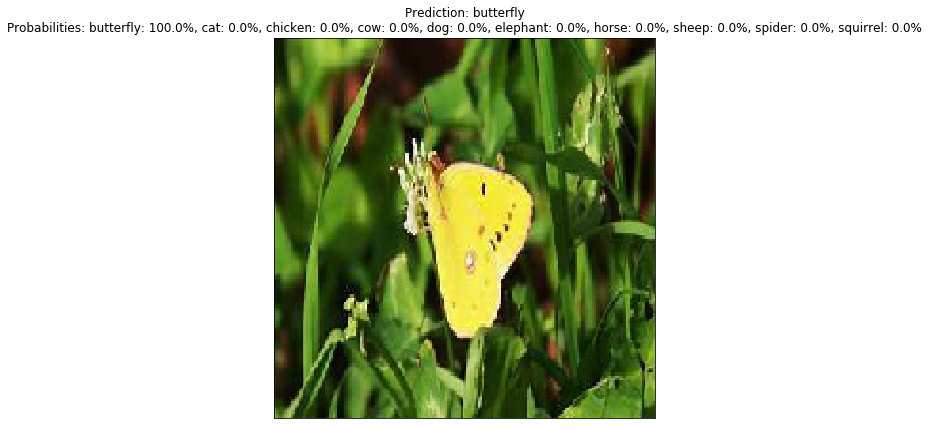

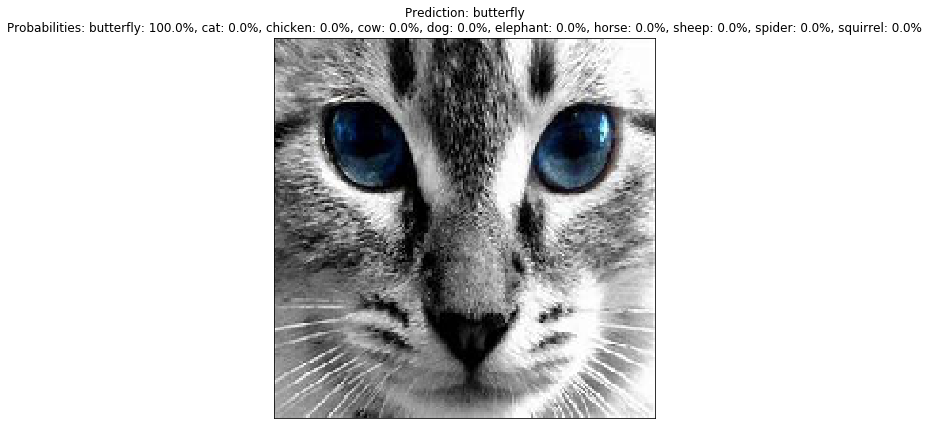

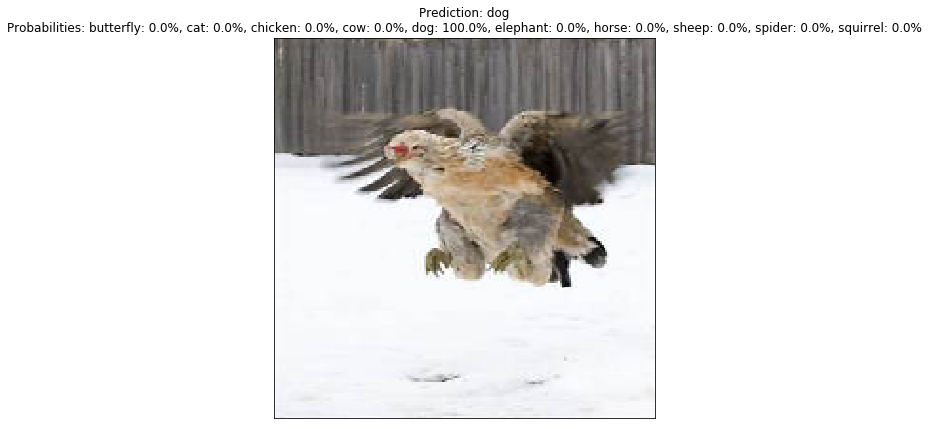

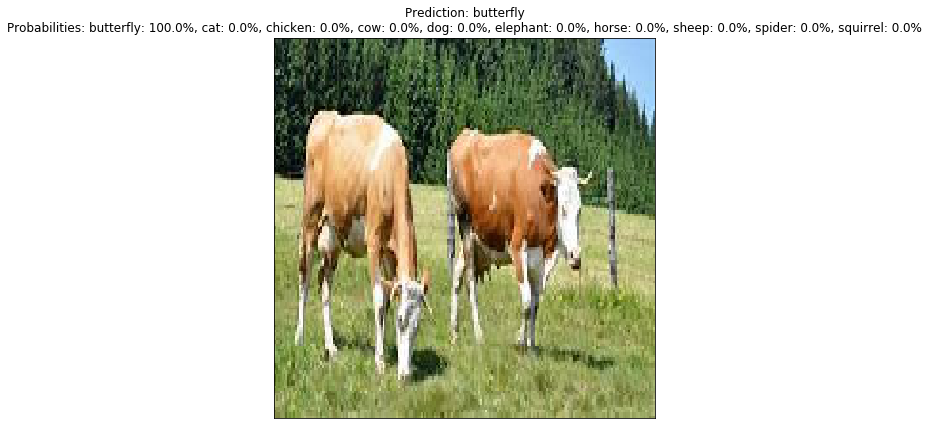

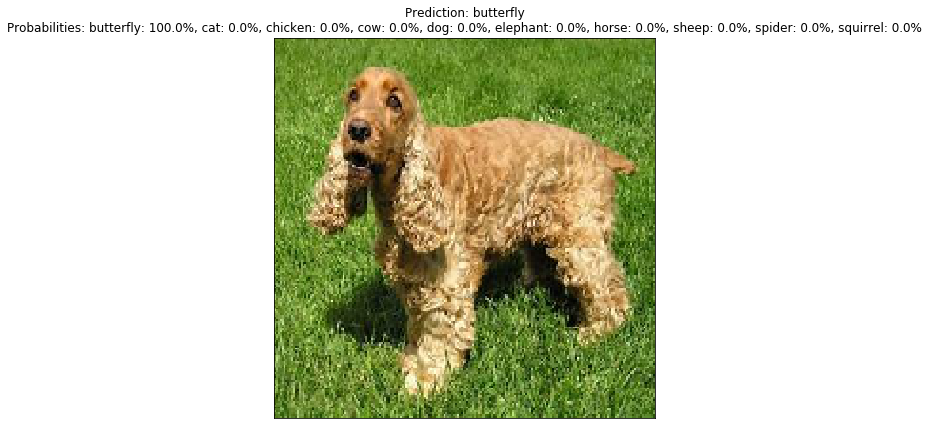

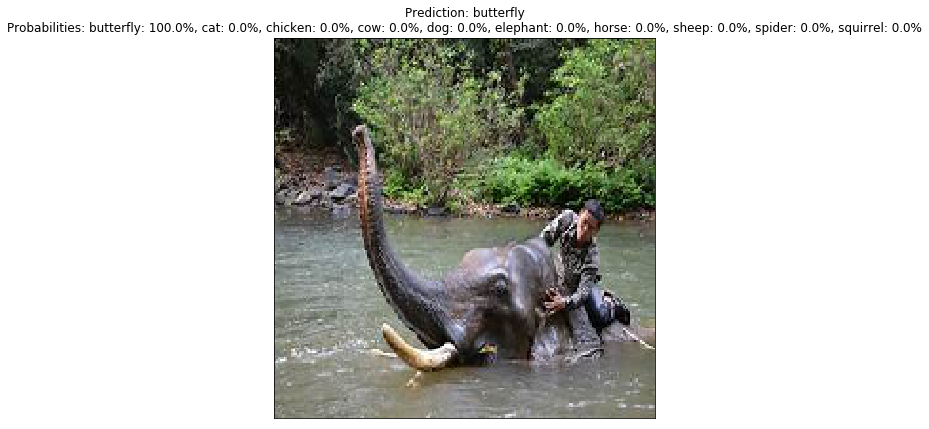

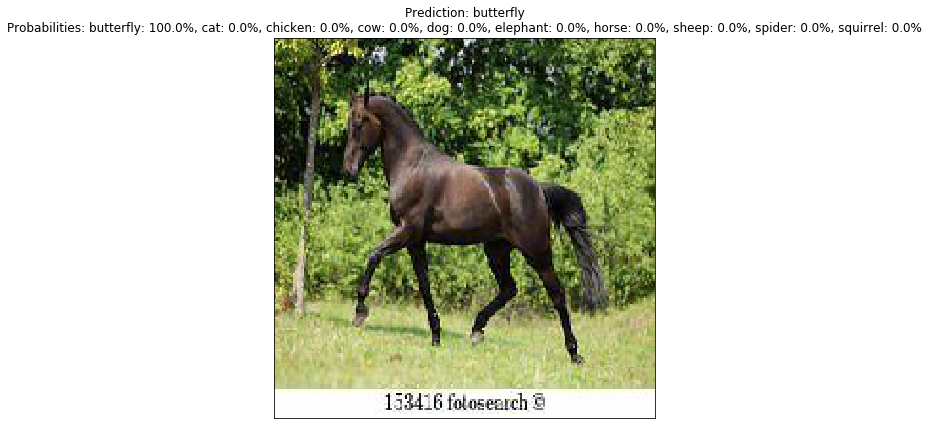

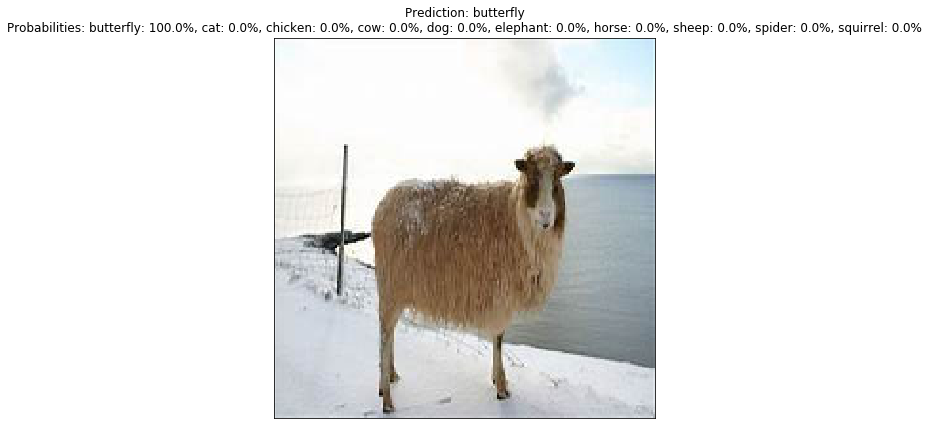

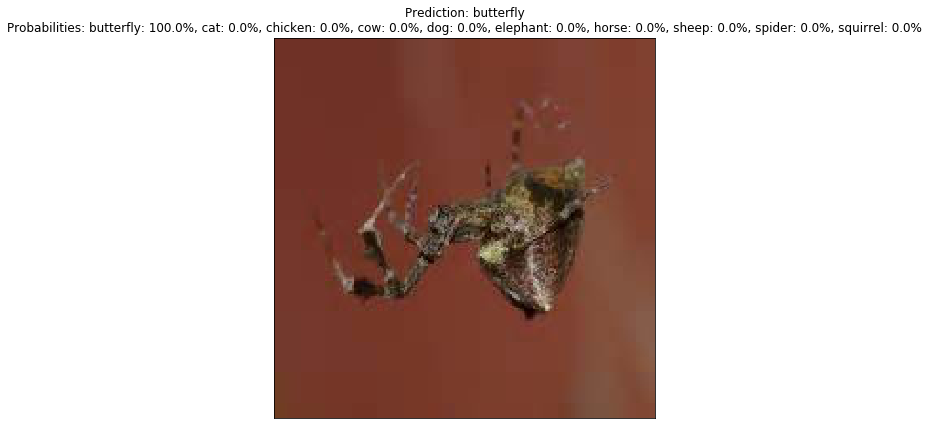

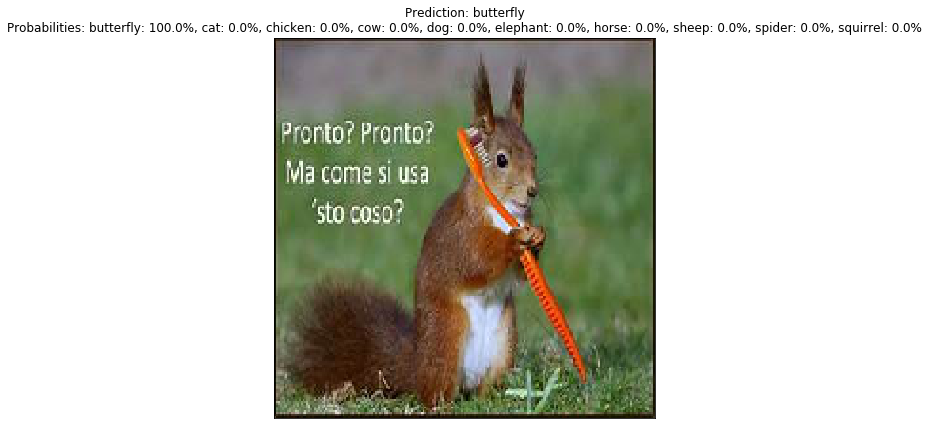

In [25]:
# Make 1 prediction per class
predictions = predict(10, predict_image_paths, model)

# plot the image that was predicted
plot_prediction(class_keys, predict_image_paths, predictions)

## Exporting the Trained Model
What do we do with a trained model? Export for your applications! 

We can use the train model instead of training it every time we want to use. There are many formats you can export it in. Here, we will export it so that it can be loaded up by this notebook

In [26]:
# export the model for later
model.save(model_name)

## Next Steps
In my next blog post, we will explore hyperparameter sweeping to the model’s accuracy. We will also explore how we can improve the model’s architecture.

## Learning Resources
- [Andrew Ng's course on Machine Learning](https://www.coursera.org/learn/machine-learning) is considered a standard. It is often recommended.
- [Fast.ai](https://www.fast.ai/) provide many excellent courses to learn Machine Learning
- [Keras - Guide to the Sequential Model](https://keras.io/getting-started/sequential-model-guide/) is a great starter to building models with Keras.

## References
[Keras](https://keras.io/)  
[Animals 10 dataset](https://www.kaggle.com/alessiocorrado99/animals10)